In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from scipy import stats as st

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46743/status,
Dashboard: /proxy/46743/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46185,Workers: 4
Dashboard: /proxy/46743/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:45393,Total threads: 4
Dashboard: /proxy/35007/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36519,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2000-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2000-01-01'))

In [5]:
uas_trends = {}; vas_trends = {}
for k in keys:
    u = uas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[k] = MK_class.compute()
    uas_trends[k] = uas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[k] = MK_class.compute()
    vas_trends[k] = vas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    print(k)

erai
era5
cfsr
jra55
reanalysis


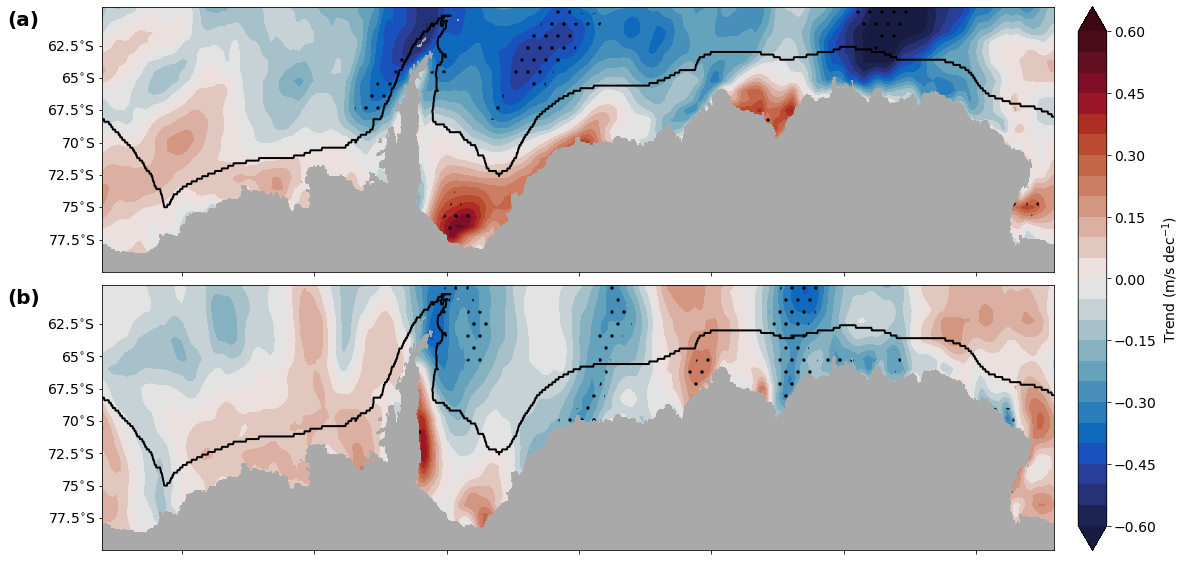

In [10]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 10))
gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03], 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[:,1])]
for ax, label in zip(axs, ['(a)', '(b)']):
    ax.text(-0.1, .93, label, transform = ax.transAxes, size = 20, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    
# Reanalysis
k = 'reanalysis'
c = axs[0].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], -uas_trends[k]['trend']*10,
                   levels = np.arange(-.6, .61, .05), extend = 'both', cmap = cmocean.cm.balance)
axs[0].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], uas_trends[k]['p'].where(uas_trends[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])

c = axs[1].contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], vas_trends[k]['trend']*10,
                   levels = np.arange(-.6, .61, .05), extend = 'both', cmap = cmocean.cm.balance)
axs[1].contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], vas_trends[k]['p'].where(vas_trends[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])
fig.colorbar(c, cax = axs[-1]).set_label('Wind speed trend (m/s decade$^{-1}$)')
plt.savefig('../results/v6/trends_pre_2000_multireanalysis.jpg', bbox_inches = 'tight')

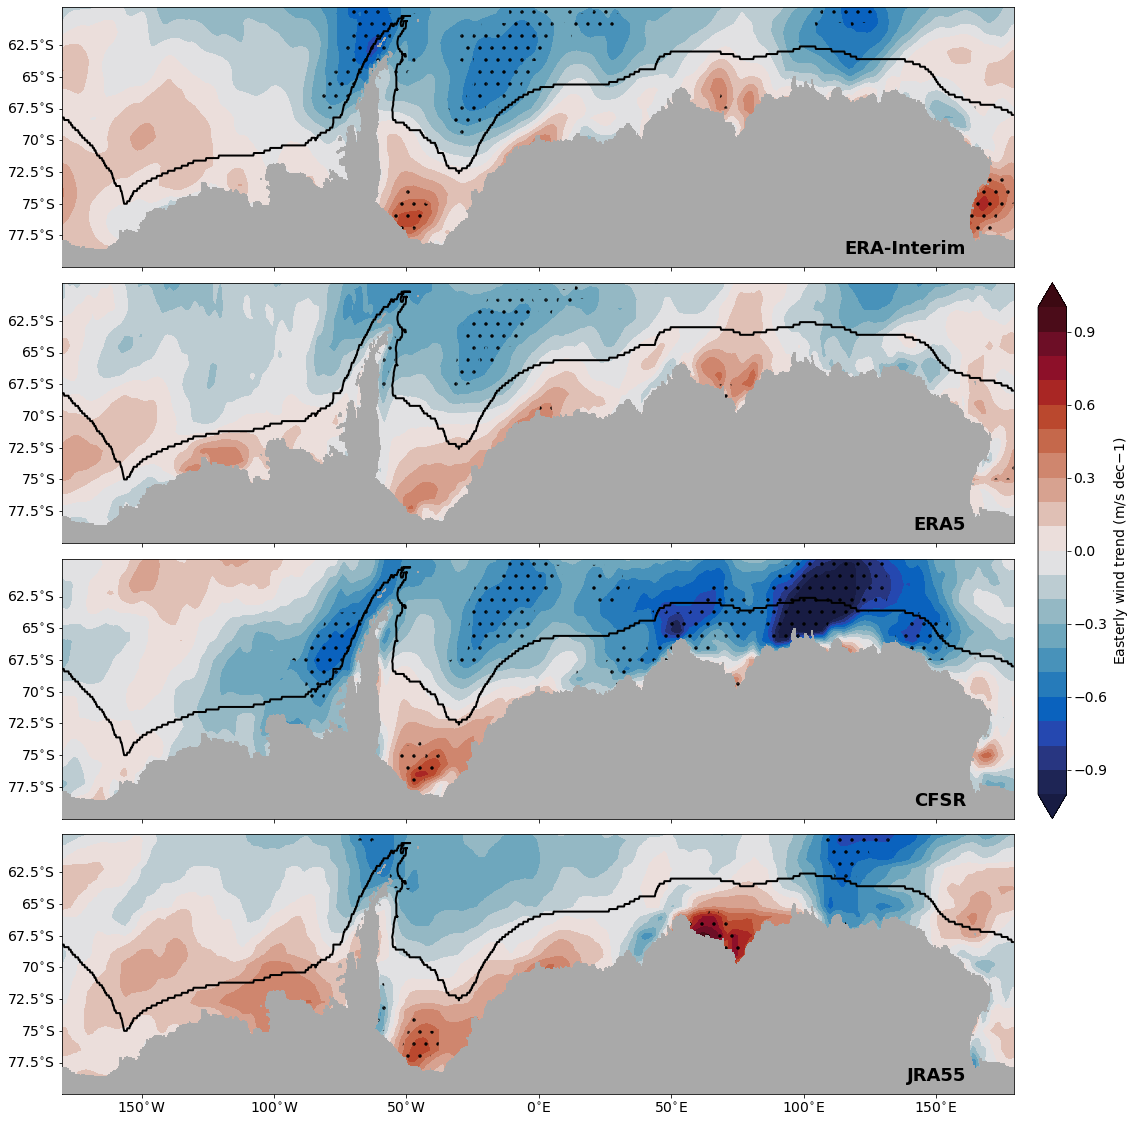

In [17]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.03], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
for ax, label in zip(axs[:-1], ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']):
    ax.text(0.95, .05, label, ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold', zorder = 5)
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                linewidths = 0.5, zorder = 3)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    
n = 0
for k in keys[:-1]:
    cf = axs[n].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], -uas_trends[k]['trend']*10, 
                         levels = np.arange(-1, 1.1, .1), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], 
                    uas_trends[k]['p'].where(uas_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Easterly wind trend (m/s dec${-1}$)')

plt.savefig('../results/v6/uas_trends_pre_2000_reanalysis.jpg', bbox_inches = 'tight')

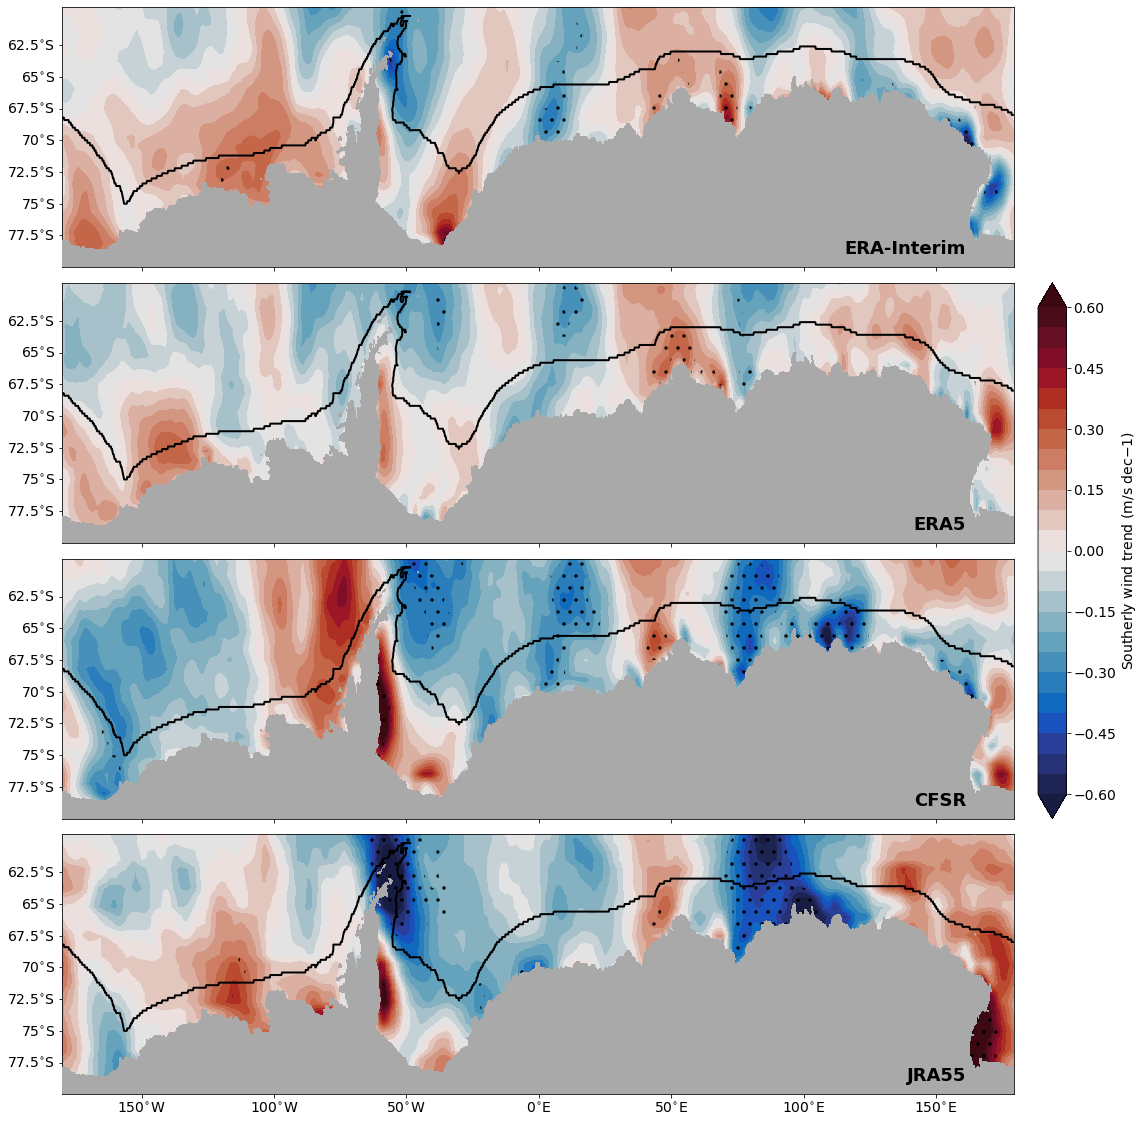

In [45]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.03], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
for ax, label in zip(axs[:-1], ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']):
    ax.text(0.95, .05, label, ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold', zorder = 5)
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                linewidths = 0.5, zorder = 3)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    
n = 0
for k in keys[:-1]:
    cf = axs[n].contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], vas_trends[k]['trend']*10, 
                         levels = np.arange(-.6, .65, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], 
                    vas_trends[k]['p'].where(vas_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Southerly wind trend (m/s dec${-1}$)')

plt.savefig('../results/v6/vas_trends_pre_2000_reanalysis.jpg', bbox_inches = 'tight')